In [ ]:
# import os
# !git clone https://github.com/aldo-fsm/fake-news-detection.git
# os.chdir('fake-news-detection')
# # !pip install pipfile-requirements
# # !pipfile2req > requirements.txt
# # !pip install -r requirements.txt
# !pip install ktrain
# ! mkdir models && mv ../SVM_rbf_20000feat_acc_0.909741 ./models/

In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
from IPython.display import display
import plotly_express as px
import plotly.io as pio
pio.renderers.default = 'colab'

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
from preprocessing import stopwords, preprocess
from datasets import fake_br_corpus

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
dataset = fake_br_corpus.loadTrain(True)

In [ ]:
import joblib
model = joblib.load('models/SVM_rbf_20000feat_acc_0.909741')

In [ ]:
from preprocessing.sentence_ranking_transformer import SentenceRankingTransformer
ranker = SentenceRankingTransformer(model, 'fake')

In [ ]:
dataset['rankedText'] = ranker.fit_transform(dataset.text)

In [ ]:
import ktrain
from ktrain import text

In [ ]:
dataset[['isFake', 'isTrue']] = dataset.label.apply(lambda label: pd.Series([1,0]) if label == 'fake' else pd.Series([0,1]))

In [ ]:
trn, val, preproc = text.texts_from_df(
  dataset,
  text_column='rankedText',
  label_columns=['isFake', 'isTrue'], 
  maxlen=512, 
  preprocess_mode='bert',
)

['isFake', 'isTrue']
      isFake  isTrue
171        0       1
3995       0       1
3905       0       1
3063       0       1
1725       0       1
['isFake', 'isTrue']
      isFake  isTrue
2366       1       0
3276       1       0
4362       1       0
2481       0       1
5967       0       1
downloading pretrained BERT model (multi_cased_L-12_H-768_A-12.zip)...
[██████████████████████████████████████████████████]
extracting pretrained BERT model...
done.

cleanup downloaded zip...
done.

preprocessing train...
language: pt


Is Multi-Label? False
preprocessing test...
language: pt


In [ ]:
model = text.text_classifier('bert', trn , preproc=preproc)

Is Multi-Label? False
maxlen is 512
done.


In [ ]:
learner = ktrain.get_learner(
  model, 
  train_data=trn, 
  val_data=val, 
  batch_size=6,
)

In [ ]:
learner.lr_find()

simulating training for different learning rates... this may take a few moments...
Epoch 1/1024
914/914 [==============================] - 1482s 2s/step - loss: 0.5895 - accuracy: 0.6525
Epoch 2/1024
914/914 [==============================] - 590s 644ms/step - loss: 1.9616 - accuracy: 0.4941


done.
Please invoke the Learner.lr_plot() method to visually inspect the loss plot to help identify the maximal learning rate associated with falling loss.


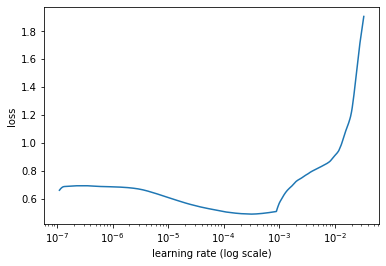

In [ ]:
learner.lr_plot()

In [ ]:
history = learner.fit_onecycle(2e-5, 1)



begin training using onecycle policy with max lr of 2e-05...
914/914 [==============================] - 1471s 2s/step - loss: 0.1955 - accuracy: 0.9174 - val_loss: 0.0975 - val_accuracy: 0.9623


In [ ]:
predictor = ktrain.get_predictor(learner.model, preproc)

In [ ]:
model.save('model')

In [ ]:
predictor.save('predictor')

In [ ]:
import shutil

In [ ]:
shutil.make_archive('model_zipado', 'zip', 'model')

'/content/fake-news-detection/model_zipado.zip'

In [ ]:
shutil.make_archive('predictor_zipado', 'zip', 'predictor')

'/content/fake-news-detection/predictor_zipado.zip'

In [ ]:
!cp -r model ../drive/MyDrive/

In [ ]:
!cp -r predictor ../drive/MyDrive/

---

In [ ]:
history2 = learner.fit_onecycle(2e-5, 5)



begin training using onecycle policy with max lr of 2e-05...
Epoch 1/5
914/914 [==============================] - 1453s 2s/step - loss: 0.0561 - accuracy: 0.9810 - val_loss: 0.1026 - val_accuracy: 0.9721
Epoch 2/5
914/914 [==============================] - 1446s 2s/step - loss: 0.0585 - accuracy: 0.9794 - val_loss: 0.0998 - val_accuracy: 0.9672
Epoch 3/5
914/914 [==============================] - 1445s 2s/step - loss: 0.0552 - accuracy: 0.9794 - val_loss: 0.0840 - val_accuracy: 0.9754
Epoch 4/5
914/914 [==============================] - 1442s 2s/step - loss: 0.0193 - accuracy: 0.9936 - val_loss: 0.0568 - val_accuracy: 0.9803
Epoch 5/5
914/914 [==============================] - 1435s 2s/step - loss: 0.0018 - accuracy: 0.9993 - val_loss: 0.0729 - val_accuracy: 0.9836


In [ ]:
model.save('model2')
!cp -r model2 ../drive/MyDrive/

In [ ]:
predictor2 = ktrain.get_predictor(learner.model, preproc)
predictor2.save('predictor2')

In [ ]:
!cp -r predictor2 ../drive/MyDrive/aaa_predictor

In [ ]:
history2.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy', 'lr', 'iterations', 'momentum'])

In [ ]:
historyDf = pd.DataFrame(dict(
  loss=history2.history['loss'],
  accuracy=history2.history['accuracy'],
  val_loss=history2.history['val_loss'],
  val_accuracy=history2.history['val_accuracy'],
))

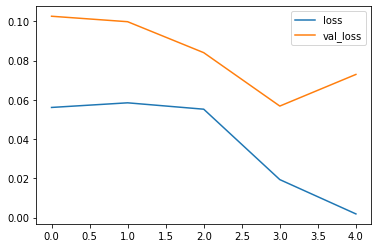

In [ ]:
historyDf[['loss', 'val_loss']].plot()

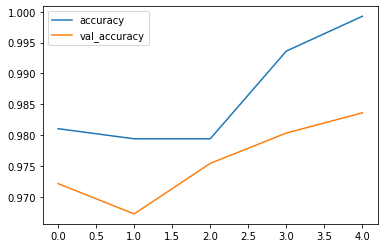

In [ ]:
historyDf[['accuracy', 'val_accuracy']].plot()

In [ ]:
from utils import evaluation

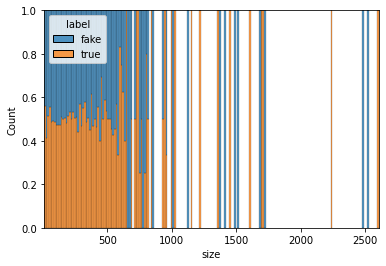

In [ ]:
evaluation.sizeDistributionByLabel(dataset.label, dataset.rankedText.apply(lambda text: len(text.split(' '))))

In [ ]:
predictor.predict(['''POLICIA Civil informa SE VOCÊ TIVER INFORTÚNIO DE SER VÍTIMA DE UM SEQÜESTRO-RELÂMPAGO, E TIVER QUE SACAR DINHEIRO NUM CAIXA ELETRÔNICO, MANTENHA A CALMA E TECLE SUA SENHA DE MANEIRA INVERSA'''])

['isTrue']

In [ ]:
predictor.predict(['''POLICIA Civil informa SE VOCÊ TIVER INFORTÚNIO DE SER VÍTIMA DE UM SEQÜESTRO-RELÂMPAGO, E TIVER QUE SACAR DINHEIRO NUM CAIXA ELETRÔNICO, MANTENHA A CALMA E TECLE SUA SENHA DE MANEIRA INVERSA.'''])

['isFake']

In [ ]:
dataset[dataset.label == 'fake'].rankedText.apply(lambda text: text.strip()[-1]).value_counts()

o    511
a    474
s    410
"    226
.    206
    ... 
v      1
V      1
N      1
|      1
D      1
Name: rankedText, Length: 69, dtype: int64

In [ ]:
dataset[dataset.label == 'true'].rankedText.apply(lambda text: text.strip()[-1]).value_counts()

o    751
a    511
s    418
)    290
e    172
    ... 
'      1
X      1
]      1
-      1
D      1
Name: rankedText, Length: 69, dtype: int64